<a href="https://colab.research.google.com/github/sumitsontakke/deep_learning/blob/main/CNN/end_to_end/cifar100_training_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import TopKCategoricalAccuracy

from sklearn.model_selection import train_test_split

In [6]:
from tensorflow.keras.datasets import cifar100

(X_train, y_train), (X_test, y_test) = cifar100.load_data()

# Normalize X data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


Parameter | Guideline
--- | ---
filters | Start small: 32 → 64 → 128 → (256)*
kernel_size | (3,3) is standard; rarely need bigger
activation | Always use 'relu'
padding | Use 'same' to maintain image size
input_shape | Only for the first Conv layer

```python
Conv2D(filters=32, kernel_size=(3,3), ...)
```

Term | Meaning
--- | ---
filters=32 | 32 different 3×3×input_channels filters are learned
Each filter | Extracts one specific kind of feature (edges, blobs, etc.)
stride | How far the filter slides per move
Output | One 2D feature map per filter, stacked into 3D output

In [7]:
model = Sequential([
    Input(shape=(32,32,3)),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.3),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.3),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 644,388 (2.46 MB)

 Trainable params: 643,940 (2.46 MB)

 Non-trainable params: 448 (1.75 KB)

In [10]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_split=0.25,
    epochs=30,
    batch_size=64,
    verbose=1
)


Epoch 1/30
586/586 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.0198 - loss: 4.7360 - val_accuracy: 0.0564 - val_loss: 4.5631
Epoch 2/30
586/586 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.0509 - loss: 4.2815 - val_accuracy: 0.1108 - val_loss: 3.8636
Epoch 3/30
586/586 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0723 - loss: 4.0632 - val_accuracy: 0.0966 - val_loss: 4.1107
Epoch 4/30
586/586 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.0926 - loss: 3.9087 - val_accuracy: 0.1568 - val_loss: 3.6418
Epoch 5/30
586/586 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.1116 - loss: 3.7838 - val_accuracy: 0.1520 - val_loss: 3.6617
Epoch 6/30
586/586 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1320 - loss: 3.6395 - val_accuracy: 0.1417 - val_loss: 3.8450
Epoch 7/30
586/586 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.1491 - loss: 3.5305 - val_accuracy: 0.2097 - val_loss: 3.3124
Epoch 8/30
586/586 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.1694 - loss: 3.4187 - val_accuracy: 

In [11]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


Test Accuracy: 0.4489, Test Loss: 2.1059


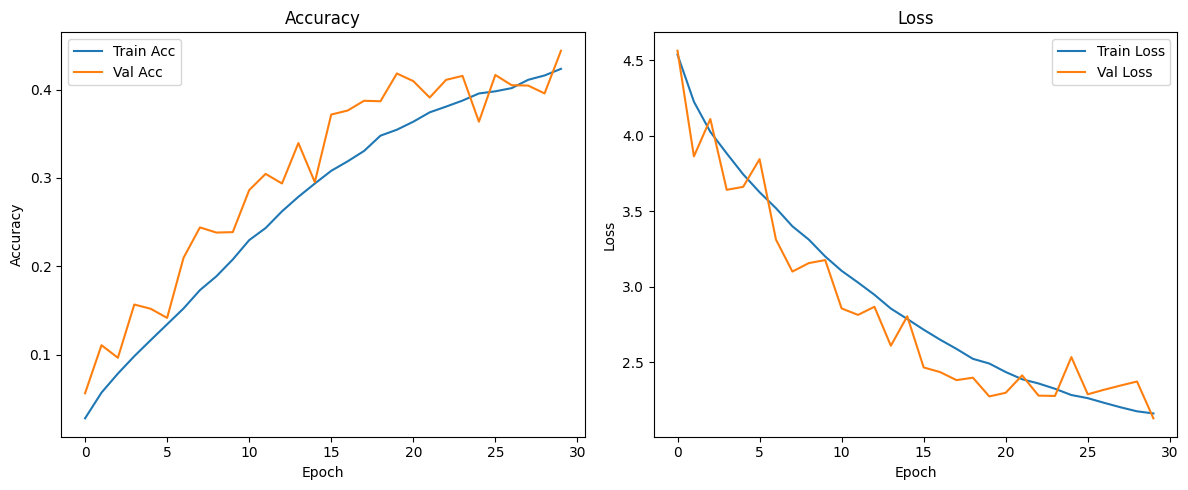

In [12]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step


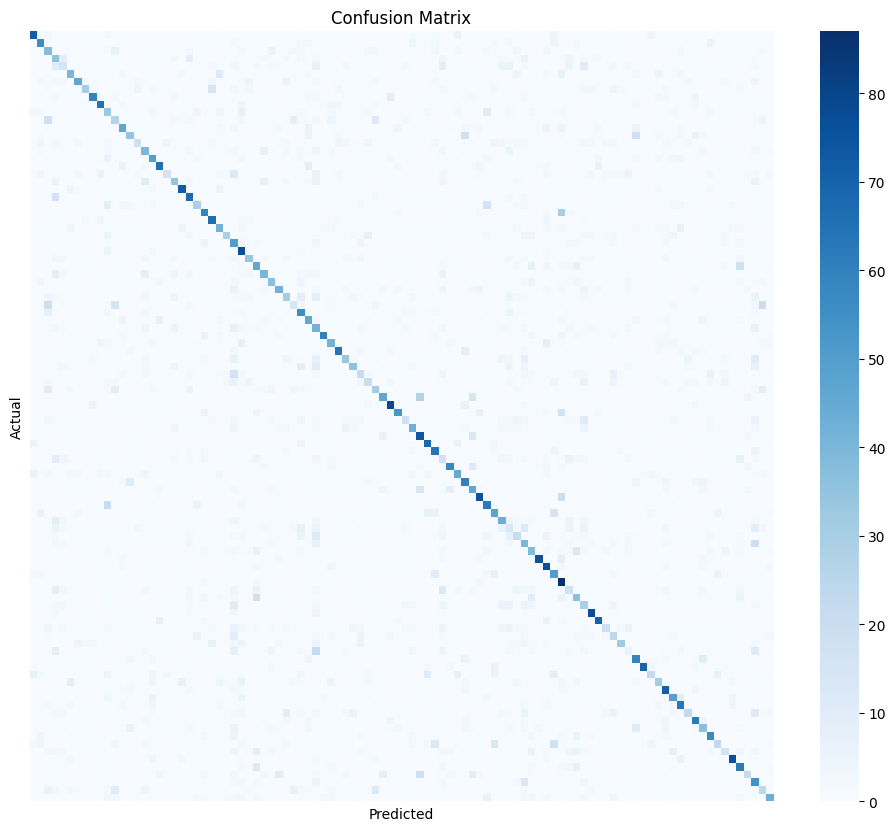

              precision    recall  f1-score   support

           0       0.70      0.72      0.71       100
           1       0.52      0.56      0.54       100
           2       0.28      0.38      0.32       100
           3       0.22      0.36      0.27       100
           4       0.21      0.15      0.17       100
           5       0.49      0.40      0.44       100
           6       0.61      0.46      0.53       100
           7       0.70      0.31      0.43       100
           8       0.69      0.59      0.63       100
           9       0.68      0.65      0.66       100
          10       0.24      0.33      0.28       100
          11       0.29      0.27      0.28       100
          12       0.51      0.46      0.48       100
          13       0.51      0.35      0.41       100
          14       0.45      0.19      0.27       100
          15       0.34      0.40      0.37       100
          16       0.48      0.49      0.49       100
          17       0.67    

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Get predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, cmap='Blues', xticklabels=False, yticklabels=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))


In [14]:
cr = classification_report(y_test, y_pred)

In [15]:
type(cr)

str

In [16]:
cr

'              precision    recall  f1-score   support\n\n           0       0.70      0.72      0.71       100\n           1       0.52      0.56      0.54       100\n           2       0.28      0.38      0.32       100\n           3       0.22      0.36      0.27       100\n           4       0.21      0.15      0.17       100\n           5       0.49      0.40      0.44       100\n           6       0.61      0.46      0.53       100\n           7       0.70      0.31      0.43       100\n           8       0.69      0.59      0.63       100\n           9       0.68      0.65      0.66       100\n          10       0.24      0.33      0.28       100\n          11       0.29      0.27      0.28       100\n          12       0.51      0.46      0.48       100\n          13       0.51      0.35      0.41       100\n          14       0.45      0.19      0.27       100\n          15       0.34      0.40      0.37       100\n          16       0.48      0.49      0.49       100\n       

In [17]:
print(cr)

              precision    recall  f1-score   support

           0       0.70      0.72      0.71       100
           1       0.52      0.56      0.54       100
           2       0.28      0.38      0.32       100
           3       0.22      0.36      0.27       100
           4       0.21      0.15      0.17       100
           5       0.49      0.40      0.44       100
           6       0.61      0.46      0.53       100
           7       0.70      0.31      0.43       100
           8       0.69      0.59      0.63       100
           9       0.68      0.65      0.66       100
          10       0.24      0.33      0.28       100
          11       0.29      0.27      0.28       100
          12       0.51      0.46      0.48       100
          13       0.51      0.35      0.41       100
          14       0.45      0.19      0.27       100
          15       0.34      0.40      0.37       100
          16       0.48      0.49      0.49       100
          17       0.67    